## P39 to 41 Export Random 1d all. 

Ok so strategically I'm thinking we show 6 3d plots and then bring the last to together: 
- Random weights, all layers expcept embedding (23, 24, 26) - let's try 24/23 first I think, and 26 can be a backup. 
- Pretrained, all layers except embedding
- Pretrained, first 8 layers -> bring these togther to start exporing in 3d. 

Nice results from overnight tests:
- pretrained_11_111_first_8_2d
- pretrained_17_117_first_8_2d
- random_10_100_last_8_2d
- random_13_103_first_8_2d
- random_16_106_first_8_2d

Still waiting on some "all" results to come in

In [1]:
# ! pip install transformers matplotlib tqdm huggingface_hub

In [2]:
# from huggingface_hub import login
# login()

In [3]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import copy
from collections import OrderedDict

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

In [4]:
model_id = "meta-llama/Llama-3.2-1B"
# model_id = "openai-community/gpt2"
# model_id = "google/gemma-3-1b-pt"
# model_id = "gpt2"

In [5]:
#Only needed for llama random initialization
config_dict = {
  "_attn_implementation_autoset": True,
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": False,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": False,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": True,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "use_cache": True,
  "vocab_size": 128256
}

In [6]:
torch.manual_seed(42)
np.random.seed(42)

In [7]:
# Random init
# model_config = GPT2Config() #Full sized model
# model = GPT2LMHeadModel(model_config).to(device) #Ok i should see what happens with full and pretrained model. 
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# # Llama with random initialization
model_config  = LlamaConfig.from_dict(config_dict)
model = LlamaForCausalLM(model_config).to(device) 
tokenizer = AutoTokenizer.from_pretrained(model_id)

#Pretrained
# model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
# tokenizer = AutoTokenizer.from_pretrained(model_id)

In [8]:
model.eval();

In [9]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

In [10]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()
print(my_loss.item(), outputs.loss.item())

12.494719505310059 12.494719505310059


In [11]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()

paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
print(my_loss.item(), outputs.loss.item(), paris_only_loss)

12.494719505310059 12.494719505310059 12.149522206513305


In [12]:
def get_random_directions(params, seed=None):
    """
    Generate random direction vectors for each parameter tensor.
    
    Args:
        params: List of (name, parameter) tuples from model.named_parameters()
        seed: Random seed for reproducibility
        
    Returns:
        direction: OrderedDict mapping parameter names to random direction tensors
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    direction = OrderedDict()
    for name, param in params:
        if param.requires_grad:
            direction[name] = torch.randn_like(param.data)
    
    return direction

In [13]:
def normalize_direction(direction, params):
    """
    Normalize the direction tensors to match the norm of each parameter tensor.
    
    Args:
        direction: OrderedDict mapping parameter names to direction tensors
        params: List of (name, parameter) tuples from model.named_parameters()
        
    Returns:
        normalized_direction: OrderedDict with normalized direction tensors
    """
    param_dict = OrderedDict(params)
    normalized_direction = OrderedDict()
    
    for name, dir_tensor in direction.items():
        param_norm = torch.norm(param_dict[name].data)
        dir_norm = torch.norm(dir_tensor)
        
        # Avoid division by zero
        if dir_norm > 0:
            normalized_direction[name] = dir_tensor * (param_norm / dir_norm)
        else:
            normalized_direction[name] = dir_tensor
    
    return normalized_direction

In [14]:
# filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
# filtered_params = filtered_params[:64] #Should be close to what i was doing before, don't do all tensors yet
# filtered_params = filtered_params[1:] #Everythign except embeddings - some nice structure here for sure, alittle more parabolic than I woudl like
# filtered_params = filtered_params[1:9] #First Layer
# filtered_params = filtered_params[1:37] #First 4 layers - pretty nice
# filtered_params = filtered_params[1:46] #First 5 layers - some nice structure here
# filtered_params = filtered_params[1:73] #First 8 layers - I like this - facorite so far
# filtered_params = filtered_params[:73] #First 8 layers including embedding - i slightly prefer the no embeddings vesrion for the 1 direction I looked at. 
# filtered_params = filtered_params[1:109] #First 12 layers - I like this too. 
# filtered_params = filtered_params[136:] #Last layer - meh prettty smooth
# filtered_params = filtered_params[99:] #Last 4 layers - ok, not amazing.
# filtered_params = filtered_params[73:] #Last 8 layers - some nice structue, but yeah more parabolic than I would like. 

## Start with 1d Projections

In [15]:
# random_seed_1=23
# # random_seed_2=117

# filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
# filtered_params = filtered_params[1:73] #First 8 layers

# # Generate and normalize random directions
# direction1 = get_random_directions(filtered_params, seed=random_seed_1)
# direction1 = normalize_direction(direction1, filtered_params)

# original_params = OrderedDict()
# for name, param in filtered_params:
#     original_params[name] = param.data.clone()

# num_points=512
# alphas=np.linspace(-2.5, 2.5, num_points)

# losses=[]
# with torch.no_grad():
#     for i, alpha in enumerate(tqdm(alphas)):
#         for name, param in model.named_parameters():
#             if name in direction1:
#                 param.data = original_params[name] + alpha * direction1[name]
        
#         outputs = model(input_ids, labels=input_ids)
#         my_probs=F.softmax(outputs.logits, dim=-1)
#         paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
#         losses.append(paris_only_loss)
    
#     for name, param in model.named_parameters(): # Restore original parameters
#         if name in original_params: 
#             param.data.copy_(original_params[name])

# plt.plot(alphas, losses)

100%|█████████████████████████████████████████████████████| 4096/4096 [02:24<00:00, 28.38it/s]


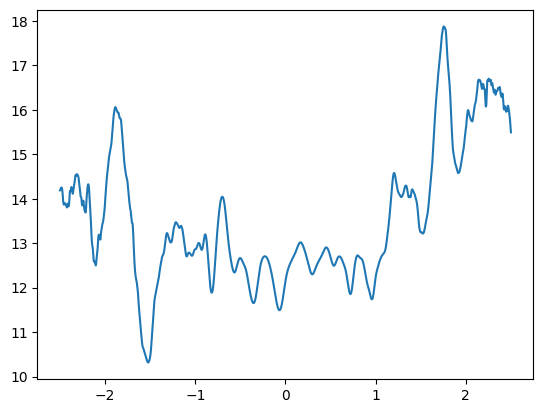

In [17]:
save_dir='/home/stephen/backparopagation/apr_24_5'

# for random_seed_1 in range(15, 100):
for random_seed_1 in [29, 51, 64, 55, 72, 27]:
# random_seed_2=117

    filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
    # filtered_params = filtered_params[1:73] #First 8 layers
    filtered_params = filtered_params[1:]
    
    # Generate and normalize random directions
    direction1 = get_random_directions(filtered_params, seed=random_seed_1)
    direction1 = normalize_direction(direction1, filtered_params)
    
    original_params = OrderedDict()
    for name, param in filtered_params:
        original_params[name] = param.data.clone()
    
    num_points=4096
    alphas=np.linspace(-2.5, 2.5, num_points)
    
    losses=[]
    with torch.no_grad():
        for i, alpha in enumerate(tqdm(alphas)):
            for name, param in model.named_parameters():
                if name in direction1:
                    param.data = original_params[name] + alpha * direction1[name]
            
            outputs = model(input_ids, labels=input_ids)
            my_probs=F.softmax(outputs.logits, dim=-1)
            paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
            losses.append(paris_only_loss)
        
        for name, param in model.named_parameters(): # Restore original parameters
            if name in original_params: 
                param.data.copy_(original_params[name])
    
    plt.clf()
    plt.plot(alphas, losses)
    plt.savefig(save_dir+'/'+'all_execpt_embedding_random_'+str(random_seed_1)+'.png')
    np.save(save_dir+'/'+'all_execpt_embedding_random_'+str(random_seed_1), np.vstack((alphas, np.array(losses))))

In [ ]:
np.vstack((alphas, np.array(losses))).shape

In [ ]:
random_seed_1=23
random_seed_2=117

filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
filtered_params = filtered_params[1:73] #First 8 layers

# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=random_seed_1)
direction1 = normalize_direction(direction1, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

num_points=512
alphas=np.linspace(-2.5, 2.5, num_points)

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

In [ ]:
model.eval()

In [ ]:
random_seed_1=17
random_seed_2=117

filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
filtered_params = filtered_params[1:73] #First 8 layers

# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=random_seed_1)
direction1 = normalize_direction(direction1, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

num_points=128
alphas=np.linspace(-2.5, 2.5, num_points)

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)